## Main Steps

### 0. Data Exploration

### 1. Extract Features
* Color Space: RGB, HLS
* Gradients
* Hog Features

### 2. Create Feature Vector
### 3. Train a Classifier
* SVM
* RF

### 4. Slide Windows on the Images
* Basic one - scan all the tempates to get HOG
* Draw the Hog of the whole picture and then extract features

### 5. Create a Pipline
### 6. Combine the vehicle detection pipeline and the lane detection pipeline
* Vehicle detection pipeline
* Lane detection pipeline

### 7. Apply the combined pipline on the video

## Version Update
* [Done] Change color space from RGB to YCbCr;
* [TODO] Increase the dataset;
* [Done] Increase HOG channel;
* [TODO] Convert the HOG feature once and extract them later;
* [Done] Change test ratio to 0.2;
* [Done] Change search window to 64by64 and 128by128;
* [Done] Change overlap ratio to 0.75;
* [Done] Change search region to (400, 656) of y;
* [TODO] Smoothing among several frames;
* [TODO] Add parallel computing to moviepy;

## 0. Data Exploration
This process prepares images for training and validation of the classifier

In [43]:
import glob
import queue

global model
global X_scaler
global box_queue

box_queue = queue.Queue(maxsize=5)

# Defines a function to collect all the training images for classfier
def data_explorer(image_folder):
    images = glob.glob(image_folder+'**/*.jpeg', recursive=True)
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)
    return cars, notcars

car_imgs, notcar_imgs = data_explorer('data/vehicles_and_non_vehicles/')
# print(notcar_imgs[0:5])

## 1. Extract Features
* Color histogram features
* Gradients features
* Hog features

In [44]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog

image = mpimg.imread('test_images/test1.jpg')

# 1. Spatial color features: define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# 2. Color histogram features: define a function to compute binned color features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# 3. HOG features: Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_fixed(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Apply get_hog_features() to extract hog features
        hog_features = get_hog_features(feature_image, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

# Convert color space
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 2. Create feature vector

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Define a function to create feature and labels
def create_train_test_data(data_path, spatial=32, histbin=32, test_ratio=0.3):
    cars, notcars = data_explorer(data_path)
    car_features = extract_features(cars, color_space='YCrCb', spatial_size=(spatial, spatial),
                        hist_bins=histbin)
    notcar_features = extract_features(notcars, color_space='YCrCb', spatial_size=(spatial, spatial),
                        hist_bins=histbin)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=rand_state)
    
    # Fit a per-column scaler only on the training data
    X_scaler_trained = StandardScaler().fit(X_train)
    # Apply the scaler to X_train and X_test
    X_train = X_scaler_trained.transform(X_train)
    X_test = X_scaler_trained.transform(X_test)
    return X_train, y_train, X_test, y_test, X_scaler_trained


image_path = 'data/vehicles_and_non_vehicles/'
X_train, y_train, X_test, y_test, X_scaler = create_train_test_data(image_path, test_ratio=0.1)
print('X_train =', X_train.shape)
print('X_test =', X_test.shape)



X_train = (2088, 8460)
X_test = (233, 8460)


## 3. Train a classifier

In [46]:
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create a classifer: SVM
def svm_classifier(train_features, train_labels):
    clf = LinearSVC()
    t=time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    return clf

# Create a classifier: SVM with Grid Search
def svm_grid_search_classifier(train_features, train_labels, return_best_parameters=False):
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 50]}
    svr = SVC()
    t=time.time()
    clf = GridSearchCV(svr, parameters)
    clf.fit(train_features, train_labels)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC with grid search...')
    if return_best_parameters == True:
        return clf, clf.best_params_
    else:
        return clf

# Create a classifier: Random Forest with Grid Search
def rf_classifier(train_features, train_labels):
    parameters = {'n_estimators':[10, 50, 100, 500]}
    rf = RandomForestClassifier()
    t=time.time()
    clf = GridSearchCV(rf, parameters)
    clf.fit(train_features, train_labels)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train RF with grid search...')
    return clf

# model = svm_classifier(X_train, y_train)
model = svm_grid_search_classifier(X_train, y_train)
print("Accuracy of SVC is  ", model.score(X_test,y_test) )
# model = rf_classifier(X_train, y_train)

252.67 Seconds to train SVC with grid search...
Accuracy of SVC is   1.0


## 4. Slide and search windows on the Images

In [47]:
# Extract features from a single image: define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def extract_single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(32, 32), xy_overlap=(0.7, 0.7)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int(img.shape[0]*0.5)
    if y_start_stop[1] == None:
        y_start_stop[1] = int(img.shape[0]*0.86)
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def slide_window_list_org(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window_list=[(32, 32)], xy_overlap=(0.7, 0.7)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = int(0.5*img.shape[1])
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int(img.shape[0]*1/2)
    if y_start_stop[1] == None:
        y_start_stop[1] = int(img.shape[0]*6/7)
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Initialize a list to append window positions to
    window_list = []
    for xy_window in xy_window_list:
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
            
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def slide_window_list(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window_list=[(32, 32)], xy_overlap=(0.7, 0.7)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = int(0.5*img.shape[1])
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int(img.shape[0]*1/2)
    if y_start_stop[1] == None:
        y_start_stop[1] = int(img.shape[0]*6/7)
        
    
    # Initialize a list to append window positions to
    window_list = []
    for xy_window in xy_window_list:
        if xy_window[0] <= 64:
            y_start_stop[0] = int(img.shape[0]*1/2)
            y_start_stop[1] = int(img.shape[0]*5/7)
            
            # Compute the span of the region to be searched    
            xspan = x_start_stop[1] - x_start_stop[0]
            yspan = y_start_stop[1] - y_start_stop[0]
        
            # Compute the number of pixels per step in x/y
            nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
            ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
            # Compute the number of windows in x/y
            nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
            ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
            nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
            ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

            # Loop through finding x and y window positions
            for ys in range(ny_windows):
                for xs in range(nx_windows):
                    # Calculate window position
                    startx = xs*nx_pix_per_step + x_start_stop[0]
                    endx = startx + xy_window[0]
                    starty = ys*ny_pix_per_step + y_start_stop[0]
                    endy = starty + xy_window[1]
            
                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
        else:
            y_start_stop[0] = int(img.shape[0]*3/5)
            y_start_stop[1] = int(img.shape[0]*6/7)
            
            # Compute the span of the region to be searched    
            xspan = x_start_stop[1] - x_start_stop[0]
            yspan = y_start_stop[1] - y_start_stop[0]
        
            # Compute the number of pixels per step in x/y
            nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
            ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
            # Compute the number of windows in x/y
            nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
            ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
            nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
            ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

            # Loop through finding x and y window positions
            for ys in range(ny_windows):
                for xs in range(nx_windows):
                    # Calculate window position
                    startx = xs*nx_pix_per_step + x_start_stop[0]
                    endx = startx + xy_window[0]
                    starty = ys*ny_pix_per_step + y_start_stop[0]
                    endy = starty + xy_window[1]
            
                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Search windows: Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = extract_single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
#         print('features =', features.shape)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



## 5. Filt false positive

In [55]:
from scipy.ndimage.measurements import label

# Search Image: define a function to search vehicles in an image
def search_image(img, clf_model, data_scaler):
#     window_list = slide_window(img, xy_window=(64, 64))
    window_list = slide_window_list(img, xy_window_list=[(32, 32), (64, 64), (128, 128)])
    on_window_list = search_windows(img, color_space='YCrCb', windows=window_list, clf=clf_model, scaler=data_scaler)
#     searched_img = draw_boxes(img, on_window_list)
    return on_window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def box_area(box_tuple):
    return (box_tuple[1][0]-box_tuple[0][0])*(box_tuple[1][1]-box_tuple[0][1])


def find_labels(img, box_list, threshold):
    print('threshold =', threshold)
     # Get the background
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    print('labels=', labels[1])
    return labels
    

def draw_labeled_bboxes(img, labels, area_threshold=30*30):

    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        if box_area(bbox) > area_threshold:
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        else:
            pass
    # Return the image
    return img

def find_labeled_boxes(img, box_list, threshold):
    box_list = []
    
#     labels = find_labels(img, box_list, threshold)
    
        # Get the background
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
#     print('labels = ', labels[1])
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        box_list.append(bbox)
    # Return the image
    return box_list

def filter_false_positive(img, box_list, threshold=2):
    global box_queue
    threshold_2 = 2
    
    # Get the background
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
#     print('labels = ', labels[1])
    
    labeled_box_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        labeled_box_list.append(bbox)
#     print('labeled_box_list = ', labeled_box_list)
    
    # put the labeled box to frame queue
    if box_queue.qsize() >= box_queue.maxsize and len(labeled_box_list)>=1:
#         print('1')
        box_queue.get()
        box_queue.put(labeled_box_list)
    elif box_queue.qsize() < box_queue.maxsize and len(labeled_box_list)>=1:
#         print('2')
        box_queue.put(labeled_box_list)
    else:
#         print('3')
        pass
    
    box_list_refined = list(box_queue.queue)
    box_queue_list = []
    for i in box_list_refined:
        box_queue_list += i
    
#     print('box_queue size =', box_queue.qsize())
#     print('box_list_refined = ', box_list_refined)
#     print('length of box_queue_list = ', len(box_queue_list))
#     print('box_queue_list = ', box_queue_list)
    
    # Get the background
    heat_2 = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat_2 = add_heat(heat_2, box_queue_list)
    # Apply threshold to help remove false positives
    heat_2 = apply_threshold(heat_2, threshold_2)
    # Visualize the heatmap when displaying
    heatmap_2 = np.clip(heat_2, 0, 255)
    # Find final boxes from heatmap using label function
    labels_2 = label(heatmap_2)
#     print('labels = ', labels_2[1])
    
    # Draw the heatmap on the image
    drawn_img = draw_labeled_bboxes(np.copy(img), labels_2)   
    return drawn_img


# def filter_false_positive(img, box_list, threshold=2):
#     global box_queue

#     # ------- smoothing -------
#     # Find labeled boxes
#     labeled_boxes = find_labeled_boxes(np.copy(img), box_list, threshold)
#     print('bbox_list = ', box_list)
#     print('labeled_boxes=', labeled_boxes)
#     # put the labeled box to frame queue
#     if box_queue.qsize() >= box_queue.maxsize and len(labeled_boxes)>=1:
#         print('1')
#         box_queue.get()
#         box_queue.put(labeled_boxes)
#     elif box_queue.qsize() < box_queue.maxsize and len(labeled_boxes)>=1:
#         print('2')
#         box_queue.put(labeled_boxes)
#     else:
#         print('3')
#         pass
    
#     box_list_refined = list(box_queue.queue)
#     print('box_queue size =', box_queue.qsize())
#     print('box_list_refined = ', box_list_refined)
#     labels =  find_labels(img, box_list_refined, threshold)
    
#     # Draw the heatmap on the image
#     drawn_img = draw_labeled_bboxes(np.copy(img), labels)   
#     return drawn_img

## 6. Create a process pipeline
bbox_list =  [((480, 360), (608, 488)), ((512, 360), (640, 488)), ((576, 360), (704, 488))]

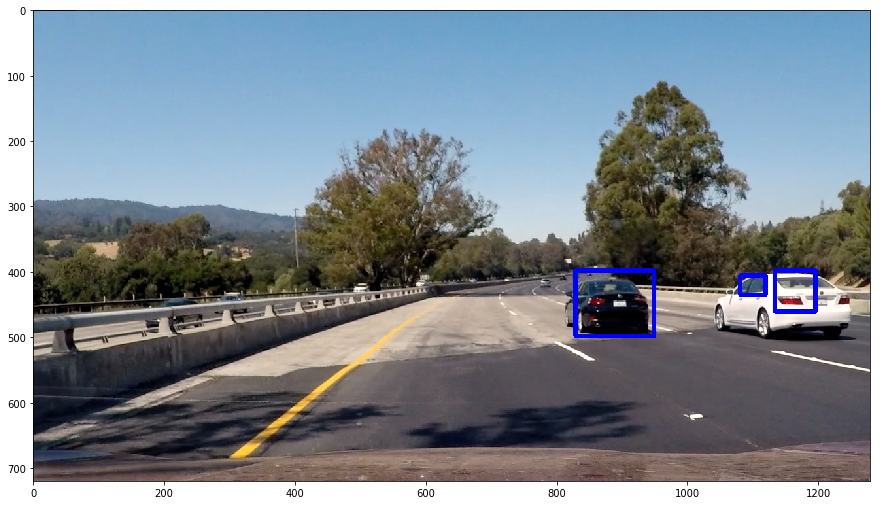

In [64]:
# image process pipeline
def image_process_pipeline(img):
    global model
    global X_scaler
    bbox_list = search_image(img, clf_model=model, data_scaler=X_scaler)
    
    refined_img = filter_false_positive(img, box_list=bbox_list, threshold=1)
    return refined_img


# smooth image process pipeline
def image_process_pipeline_smooth(img):
    global model
    global X_scaler
    global box_queue
    bbox_list = search_image(img, clf_model=model, data_scaler=X_scaler)
    refined_img = filter_false_positive(img, box_list=bbox_list, threshold=1)
    return refined_img

image = mpimg.imread('test_images/test4.jpg')
processed_image = image_process_pipeline(image)
plt.figure(figsize=(15, 10))
plt.imshow(processed_image)

## 7. Process of the video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_video/marked_img.mp4'
clip1 = VideoFileClip("project_video.mp4")
# clip1 = VideoFileClip("project_video.mp4").subclip(20, 22)
# clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(image_process_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output_video/marked_img.mp4
[MoviePy] Writing video output_video/marked_img.mp4



 12%|█▏        | 147/1261 [33:24<4:13:14, 13.64s/it]


 15%|█▍        | 183/1261 [41:47<4:06:12, 13.70s/it]

In [51]:
import queue
L = queue.Queue(maxsize=3)
L.put(3)
L.put(4)
L.put(5)
L.get()
L.put(6)
L.get()

list_L = list(L.queue)

print('list_L = ', list_L)
print('L = ', L.qsize())

list_L =  [5, 6]
L =  2
